# Modelling and analysing RNA circuit dynamics

Computational tools in synthetic biology are becoming increasingly sophisticated. The first comprehensive cell simulation was published recently for E. coli [reference] and it seems that every week there is a new neural network-based predictor for core genetic parts such as promoters, toehold sequences and and ribosome binding sites [references].

In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.testing.shared import CONFIG
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config

CONFIG = prepare_config(CONFIG)

We will import some data summarising a previous simulation of 2000 randomly generated RNA circuits and their mutated iterations. For each starting or "reference" circuit, a mutated circuit was generated with $m$ mutations on each RNA species $s$ in the circuit. Because each of these mutations is administered randomly, some $n$ number of versions is repeated for each mutated iteration with $m$ mutations on species $s$. The exact settings for this dataset were the following:

$$
m = [1, 2, 3, 5, 10, 15]
$$
$$
s = [RNA_0, RNA_1, RNA_2]
$$
$$
n = 10
$$

This means that for each circuit, 6 mutated iterations $m$ were generated for each of the 3 RNA species $s$ with $n = 10$ samples for each, giving 180 mutated circuits for each reference circuit and thus a total of $2000 * 181 = 362000$ circuits.

# Case study: studying specific circuits' dynamics


## Choosing circuits with similar and different dynamics

In order to find good candidates for a case study, we want to look at circuits where some have similar dynamics metrics between them, some have vastly different dynamics but similar values, and some have highly varying metrics on all accounts. We especially want to look at circuits with possible contradictions, such as those where the minimum and maximum values reached by the signalling RNA ($RNA_0$) are similar, yet some of the signal analytics suggest a big change between these values.

### Load Data

In [3]:
fn = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'
og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'
data = pd.read_csv(fn)
# data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)
# dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)


### Get means and STDs

In [4]:
analytics = [c for c in get_true_names_analytics(data) if ('sensitivity' in c) or ('precision' in c)]
# agg1 = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: 'std' for c in analytics})
agg1_stds = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.std(x) if sum(x) != 0.0 else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})
agg1_mean = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.mean(x) if sum(x) != 0.0 else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})

### Find circuits with optimal distance in their function

Here we are looking at the circuits with minimal distance between their sensitivities and precisions, while having a maximum distance between the variation of the change in their precision between reference and mutated circuits, so the standard deviation of the precision ratio between from a mutant to it reference circuit.

In [5]:
filts = (agg1_mean['sample_name'] == 'RNA_2') & (agg1_mean['precision_wrt_species-6'] != np.inf) & (agg1_mean['precision_wrt_species-6'] > 1) & ((agg1_mean['num_interacting'] > 1) | (agg1_mean['num_self_interacting'] > 1))

p = agg1_mean[filts]['precision_wrt_species-6'].to_numpy()
s = agg1_mean[filts]['sensitivity_wrt_species-6'].to_numpy()
st = agg1_stds[filts]['precision_wrt_species-6_ratio_from_mutation_to_base'].to_numpy()

std_diffs = np.log(st[:, None] / st[None, :])
prec_diffs = np.log(p[:, None] / p[None, :])
sens_diffs = np.log(s[:, None] / s[None, :])

std_diffs = np.where(np.isnan(std_diffs) | (np.abs(std_diffs) == np.inf), 0, std_diffs)
weighting_prec = 1
weighting_sens = 1
joint_diffs = weighting_prec * np.abs(prec_diffs) + weighting_sens * np.abs(sens_diffs)
joint_diffs_rev = np.where(joint_diffs != 0, joint_diffs.max() - np.abs(joint_diffs), 0)
joint = joint_diffs_rev + np.abs(std_diffs)

circ1, circ2 = np.where(joint == np.abs(joint).max()) 
circ1, circ2 = np.array(list(set([tuple(sorted([c1, c2])) for c1, c2 in zip(circ1, circ2)]))).T

circ1_m_df = agg1_mean[filts].iloc[circ1]
circ2_m_df = agg1_mean[filts].iloc[circ2]
circ1_s_df = agg1_stds[filts].iloc[circ1]
circ2_s_df = agg1_stds[filts].iloc[circ2]


/var/folders/89/b14m_l9d4h58lnx67_8_2p440000gn/T/ipykernel_12945/3656149399.py:7: RuntimeWarning: divide by zero encountered in divide
  std_diffs = np.log(st[:, None] / st[None, :])
/var/folders/89/b14m_l9d4h58lnx67_8_2p440000gn/T/ipykernel_12945/3656149399.py:7: RuntimeWarning: invalid value encountered in divide
  std_diffs = np.log(st[:, None] / st[None, :])
/var/folders/89/b14m_l9d4h58lnx67_8_2p440000gn/T/ipykernel_12945/3656149399.py:7: RuntimeWarning: divide by zero encountered in log
  std_diffs = np.log(st[:, None] / st[None, :])


### Check that the expected circuits were selected

Visualising the precision and sensitivity of the circuits, along with the variation in precision ratio.

ValueError: could not broadcast input array from shape (41996,) into shape (42000,)

Error in callback <function _draw_all_if_interactive at 0x7fb8a05c7a60> (for post_execute):


ValueError: could not broadcast input array from shape (41996,) into shape (42000,)

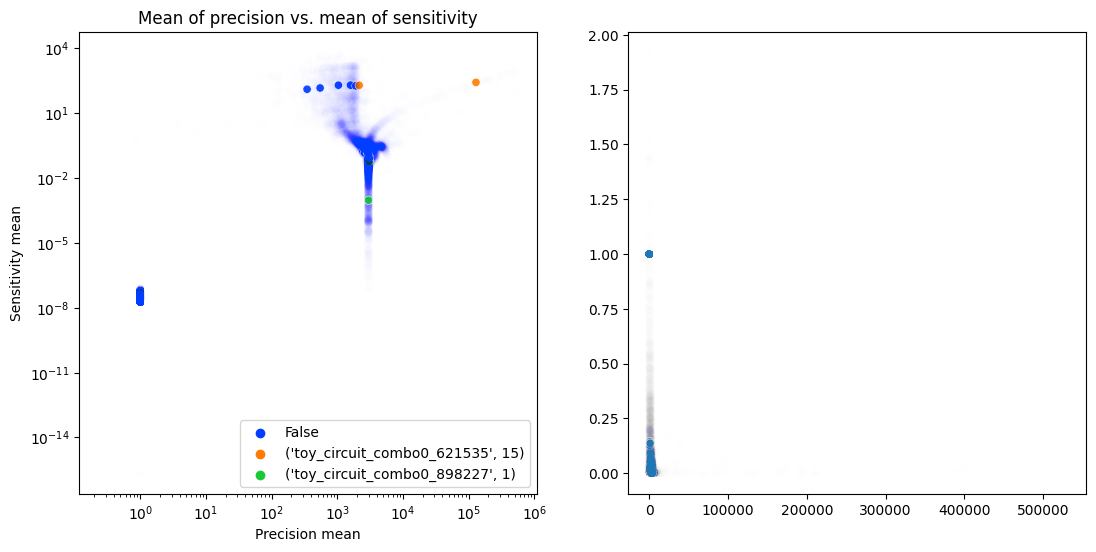

: 

In [12]:
c1n, c1m = circ1_m_df['circuit_name'].values[0], circ1_m_df['mutation_num'].values[0]
c2n, c2m = circ2_m_df['circuit_name'].values[0], circ2_m_df['mutation_num'].values[0]
alpha = (agg1_mean[agg1_mean['precision_wrt_species-6'] < np.inf]['circuit_name'].isin(
    [c1n, c2n])).apply(lambda x: x - 0.1 if x == 1 else x + 0.005)
# hue = agg1_stds['circuit_name'].isin([circ1_df['circuit_name'].values[0], circ2_df['circuit_name'].values[0]]).apply(lambda x: 'circ1' if x else x) & \
#     agg1_stds['mutation_num'].isin([circ1_df['mutation_num'].values[0], circ2_df['mutation_num'].values[0]]).apply(lambda x: 'circ2' if x else x)
hue_d = {c1n: c1m, c2n: c2m}
hue = jax.tree_util.tree_map(lambda c, m: (c,m) if (c in [c1n, c2n]) and (m == hue_d[c]) else False, list(agg1_mean['circuit_name'].values), list(agg1_mean['mutation_num'].values))

plt.figure(figsize=(13, 6))
ax = plt.subplot(1,2,1)
sns.scatterplot(x=agg1_mean['precision_wrt_species-6'], y=agg1_stds['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=alpha,
                hue=hue,
                palette='bright')
plt.xlabel('Precision mean')
plt.ylabel('Sensitivity mean')
plt.xscale('log')
plt.yscale('log')
plt.title('Mean of precision vs. mean of sensitivity')

alpha = (agg1_mean[(agg1_mean['precision_wrt_species-6'] < np.inf) & (agg1_mean['sensitivity_wrt_species-6'] < np.inf)]['circuit_name'].isin(
    [c1n, c2n])).apply(lambda x: x - 0.1 if x == 1 else x + 0.005)

ax = plt.subplot(1,2,2)
sns.scatterplot(x=agg1_mean['precision_wrt_species-6'], y=agg1_mean[(agg1_mean['sensitivity_wrt_species-6'] < np.inf)]['sensitivity_wrt_species-6'], 
                alpha=alpha,
                hue=hue,
                palette='bright')

## Simulate the chosen circuits

### Load circuits

In [ ]:


def load_circuit(circ_row, config, og_dir: str):

    def symmetrical_matrix_length(flattened_length):
        return int((-1 + np.sqrt(1 + 8 * flattened_length)) / 2)

    def flatten_to_matrix(flattened_vector):
        length = symmetrical_matrix_length(len(flattened_vector))
        if length == 1:
            length = int(np.sqrt(len(flattened_vector)))
            return flattened_vector.reshape((length, length))
        
        matrix = [[0] * length for _ in range(length)]
        index = 0
        for i in range(length):
            for j in range(i, length):
                matrix[i][j] = flattened_vector[index]
                matrix[j][i] = flattened_vector[index]
                index += 1
        return np.array(matrix)
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')].values.squeeze()),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')].values.squeeze()),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')].values.squeeze()),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')].values.squeeze())}
    circuit = construct_circuit_from_cfg({
        'data_path': circ_path,
        'interactions': interactions
    }, config)
    circuit.subname = circ_row['mutation_name']
    return circuit
    

def batch_load(circ_rows: pd.DataFrame, ref_c: pd.DataFrame, og_dir: str):
    circuits = []
    circuits.append(load_circuit(circ_row=ref_c.iloc[0], config=CONFIG, og_dir=og_dir))
    for i, circ_row in circ_rows.iterrows():
        circuits.append(load_circuit(circ_row=circ_row, config=CONFIG, og_dir=og_dir))
    return circuits

circ_rows1 = data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ1_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == 'RNA_0')]
ref_c1 = data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_0')]
circ_rows2 = data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ2_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == 'RNA_0')]
ref_c2 = data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_0')]
circuits1 = batch_load(circ_rows1, ref_c1, og_dir)
circuits2 = batch_load(circ_rows2, ref_c2, og_dir)
circuits = circuits1 + circuits2

forward_rates = circuits1[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits])

t0 = 0 
t1 = 200
dt = 0.001
tmax = 5000
threshold_steady_states = 0.005

signal_onehot = np.zeros_like(circuits1[0].signal.reactions_onehot) if circuits1[0].use_prod_and_deg else np.zeros_like(circuits1[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits1[0].qreactions.reactions.inputs,
                            outputs=circuits1[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, int(np.min([200, t1-t0]))))
                            )))
